In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
X_tcr_train = torch.load('/kaggle/input/pmtnet-dataem/X_tcr_train.pt')
X_antigen_train = torch.load('/kaggle/input/pmtnet-dataem/X_antigen_train.pt')
X_hla_train = torch.load('/kaggle/input/pmtnet-dataem/X_hla_train.pt')
y_train = torch.load('/kaggle/input/pmtnet-dataem/y_train.pt')
X_tcr_test = torch.load('/kaggle/input/pmtnet-dataem/X_tcr_test.pt')
X_antigen_test = torch.load('/kaggle/input/pmtnet-dataem/X_antigen_test.pt')
X_hla_test = torch.load('/kaggle/input/pmtnet-dataem/X_hla_test.pt')
y_test = torch.load('/kaggle/input/pmtnet-dataem/y_test.pt')
dataset = TensorDataset(X_tcr_train, X_antigen_train, X_hla_train, y_train)
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [2]:
class HLA_Antigen_Cross(nn.Module):
    def __init__(self, input_dim_1=21, input_dim_2=21, seq_len_1=15, seq_len_2=34, d_model=64):
        super(HLA_Antigen_Cross, self).__init__()
        self.positional_encoding_1 = nn.Parameter(torch.randn(1, seq_len_1, d_model))
        self.positional_encoding_2 = nn.Parameter(torch.randn(1, seq_len_2, d_model))
        self.linear_in_1 = nn.Linear(input_dim_1, d_model)
        self.linear_in_2 = nn.Linear(input_dim_2, d_model)
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        x1 = self.linear_in_1(x1) + self.positional_encoding_1
        x2 = self.linear_in_2(x2) + self.positional_encoding_2
        attn_output, _ = self.cross_attn(query=x2, key=x1, value=x1)
        x1_norm = self.layer_norm(attn_output + x2)
        ff_output = self.feed_forward(x1_norm)
        output = self.layer_norm(ff_output + x1_norm)
        return output

In [3]:
class TCR_pMHC_Cross(nn.Module):
    def __init__(self, input_dim_1=5, input_dim_2=64, seq_len_1=30, seq_len_2=34, d_model=64):
        super(TCR_pMHC_Cross, self).__init__()
        self.positional_encoding_1 = nn.Parameter(torch.randn(1, seq_len_1, d_model))
        self.positional_encoding_2 = nn.Parameter(torch.randn(1, seq_len_2, d_model))
        self.linear_in_1 = nn.Linear(input_dim_1, d_model) 
        self.linear_in_2 = nn.Linear(input_dim_2, d_model)
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=4, batch_first=True)
        self.layer_norm = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x1, x2):
        x1 = self.linear_in_1(x1) + self.positional_encoding_1
        x2 = self.linear_in_2(x2) + self.positional_encoding_2
        attn_output, _ = self.cross_attn(query=x1, key=x2, value=x2)
        x1_norm = self.layer_norm(attn_output + x1)
        ff_output = self.feed_forward(x1_norm)
        output = self.layer_norm(ff_output + x1_norm)
        return output

In [4]:
class THACrossModel(nn.Module):
    def __init__(self):
        super(THACrossModel, self).__init__()
        input_features = 30*5 + 15*21 + 34*21 + 64 + 64
        self.fc_sequence = nn.Sequential(
            nn.Linear(input_features, 2048),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.hla_antigen = HLA_Antigen_Cross()
        self.tcr_pMHC = TCR_pMHC_Cross()

    def forward(self, x_tcr, x_antigen, x_hla):
        x_tcr_flat = x_tcr.view(x_tcr.size(0), -1)
        x_antigen_flat = x_antigen.view(x_antigen.size(0), -1)
        x_hla_flat = x_hla.view(x_hla.size(0), -1)
        hla_antigen_matrix = self.hla_antigen(x_antigen, x_hla)
        hla_antigen_flat = hla_antigen_matrix.mean(dim=1)
        tcr_pMHC_matrix = self.tcr_pMHC(x_tcr, hla_antigen_matrix)
        tcr_pMHC_flat = tcr_pMHC_matrix.mean(dim=1)
        x = torch.cat((x_tcr_flat, x_antigen_flat, x_hla_flat, hla_antigen_flat, tcr_pMHC_flat), dim=1)
        out = self.fc_sequence(x) 
        return out

In [5]:
def train_model(train_dataset, val_dataset, model, criterion, optimizer, epochs=10):
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_tcr, x_antigen, x_hla, y in train_loader:
            x_tcr, x_antigen, x_hla, y = x_tcr.to(device), x_antigen.to(device), x_hla.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x_tcr, x_antigen, x_hla).squeeze()
            loss = criterion(outputs, y.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_tcr, x_antigen, x_hla, y in val_loader:
                x_tcr, x_antigen, x_hla, y = x_tcr.to(device), x_antigen.to(device), x_hla.to(device), y.to(device)
                outputs = model(x_tcr, x_antigen, x_hla).squeeze()
                loss = criterion(outputs, y.float())
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += y.size(0)
                correct += (predicted == y).sum().item()
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val Acc: {val_accuracies[-1]}')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = THACrossModel().to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_losses, val_losses, val_accuracies = [], [], []
train_model(train_dataset, val_dataset, model, criterion, optimizer, epochs=300)

THACrossModel(
  (fc_sequence): Sequential(
    (0): Linear(in_features=1307, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=1024, out_features=1, bias=True)
    (10): Sigmoid()
  )
  (hla_antigen): HLA_Antigen_Cross(
    (linear_in_1): Linear(in_features=21, out_features=64, bias=True)
    (linear_in_2): Linear(in_features=21, out_features=64, bias=True)
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (feed_forward): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linea

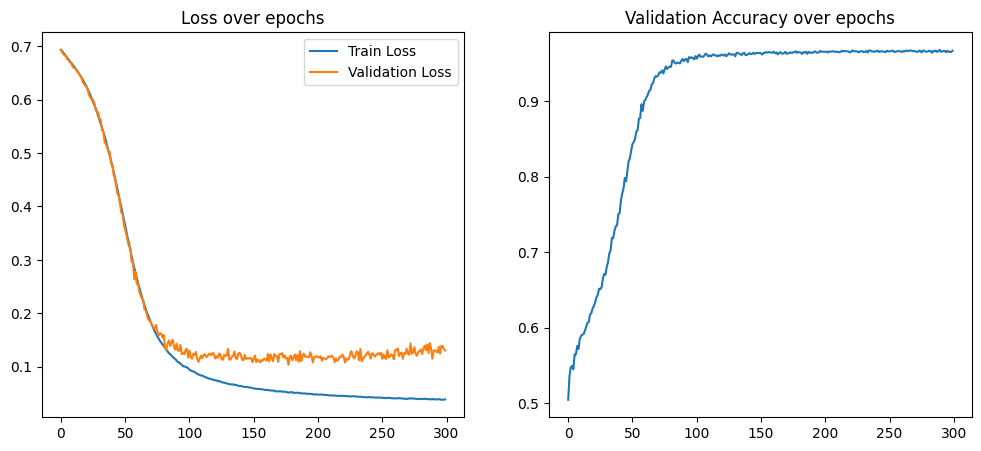

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.subplot(1, 2, 2) 
plt.plot(val_accuracies)
plt.title('Validation Accuracy over epochs')
plt.show()

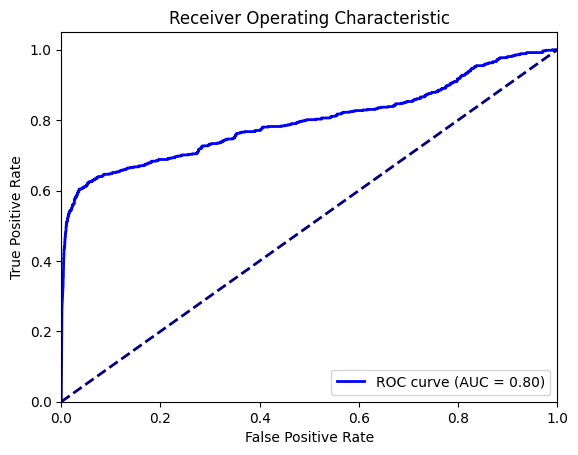

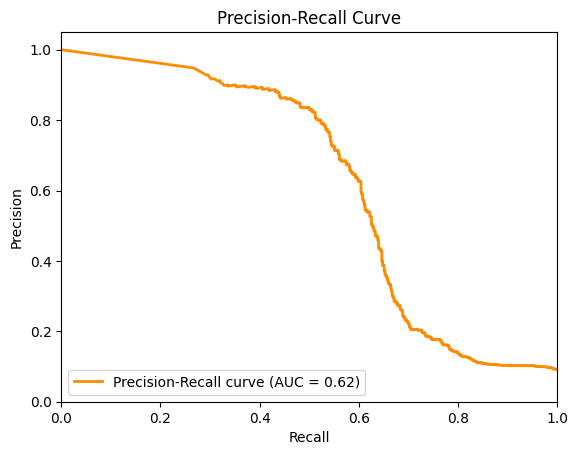

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
model.eval()
test_dataset = TensorDataset(X_tcr_test, X_antigen_test, X_hla_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
y_true = []
y_scores = []
with torch.no_grad():
    for X_tcr, X_antigen, X_hla, y in test_loader:
        X_tcr, X_antigen, X_hla, y = X_tcr.to(device), X_antigen.to(device), X_hla.to(device), y.to(device)
        outputs = model(X_tcr, X_antigen, X_hla)
        y_true.extend(y.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure(1)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure(2)
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()